<a href="https://colab.research.google.com/github/sandeepjnv/SeatAvailabilityDetection/blob/master/test_yolov3_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2022-05-16 16:04:34--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  18.1MB/s    in 14s     

2022-05-16 16:04:49 (16.8 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [11]:
import cv2
import argparse
import numpy as np


363.3141683778234
396.7130044843049


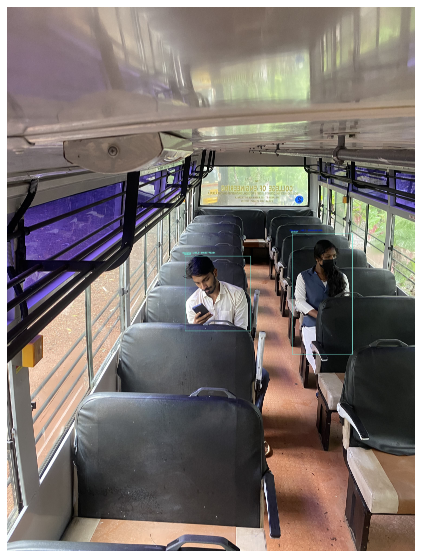

In [14]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

def get_output_layers(net):
    
    layer_names = net.getLayerNames()
    
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers


def draw_prediction(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    
image = cv2.imread('IMG1.jpg')

Width = image.shape[1]
Height = image.shape[0]
scale = 0.00392

classes = None

with open('yolov3.txt', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')

blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

net.setInput(blob)

outs = net.forward(get_output_layers(net))

class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5
nms_threshold = 0.4

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5 and class_id == 0:
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w / 2
            y = center_y - h / 2
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h,detection[2],detection[1]])


indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

for i in indices:
    i = i[0]
    box = boxes[i]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    
    # distance 
    known_distance = 222 #cm
    known_width = 40

    # focal_length = (w * known_distance)/known_width
    focal_length = 4423.35
    dist = round(known_width * focal_length)/w
    

    print(dist)
    cv2.putText(image, "Distance :"+str(dist), (round(x)-20,round(y)-20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[i], 2)
    draw_prediction(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))


cv2.waitKey()
    
cv2.imwrite("object-detection.jpg", image)
imShow('object-detection.jpg')
cv2.destroyAllWindows()